In [1]:
using Pkg

Pkg.activate("..")

using Distributions, LinearAlgebra, Random, StatsBase
using DelimitedFiles, Statistics
using CairoMakie



include("../Code/GLV.jl")

  Activating project at `~/Projects/Working/PhD/TempFeas`
Precompiling CairoMakie
  ✓ libsixel_jll
  ✓ XML2_jll
  ✓ Gettext_jll
  ✓ XSLT_jll
  ✓ Sixel
  ✓ Glib_jll
  ✓ PNGFiles
  ✓ Cairo_jll
  ✓ HarfBuzz_jll
  ✓ libass_jll
  ✓ Pango_jll
  ✓ Cairo
  ✓ FFMPEG_jll
  ✓ Makie
  ✓ CairoMakie
  15 dependencies successfully precompiled in 336 seconds. 206 already precompiled.
[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
┌ Warning: Module Distributions with build ID fafbfcfd-dfde-a1e8-0000-bee61b8848f2 is missing from the cache.
│ This may mean Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0].
Precompiling Makie
  ✓ libsixel_jll
  ✓ XSLT_jll
  ✓ Sixel
  ✓ PNGFiles
  ✓ Adapt → AdaptStaticArraysExt
  ✓ StaticArrays → StaticArraysChainRulesCoreExt
  ✓ Int

Main.GLV

In [2]:
#predict richness from distributions
function pred_richness(r, aij, aii, T_vec, N_rep, prob)
    #allocate results arrays
    simulated_richness = Array{Float64}(undef, length(T_vec))
    predicted_richness = zeros(length(T_vec))

    for (i,T) = enumerate(T_vec)
        #get trait Distributions from parameters
        dr, daij, daii = GLV.trait_temp(r, T), GLV.trait_temp(aij, T), GLV.trait_temp(aii, T)
        
        #predicted
        predicted_richness[i] = GLV.richness(prob, daij, daii, dr)
        N = Int(ceil(predicted_richness[i]))
        
        N_vec = max(N-5,1):(N+5)
        # #generators
        f_r(x...) = rand(dr, x...)
        f_aij(x...) = rand(daij, x...)
        f_aii(x...) = rand(daii, x...)

        #loop over Nvals
        p_feas = zeros(length(N_vec))
        for (k,N) = enumerate(N_vec)
            print("\r", T, " ", k)
            feas_vec = zeros(N_rep)
            Threads.@threads for j = 1:N_rep
                #generate params
                r_ = f_r(N)
                a_ = f_aij(N,N)
                [a_[ii,ii] = f_aii(1)[1] for ii = 1:N]
                #make params
                x = inv(a_) * r_ 
                feas_vec[j] = all(x .> 0)
            end
            p_feas[k] = mean(feas_vec)
        end
        #get bounds on richness
        N_indx = findmin(abs.(p_feas .- prob))
        simulated_richness[i] = N_vec[N_indx[2]]
    end
    return(simulated_richness, predicted_richness)
end


#confidence ellipse
function ErrorEllipse(dB, p)
    s = -2 * log(1 - p);

    λ = eigen(dB.Σ * s)
    
    t = range(0, 2 * pi, length = 100)
    
    a = λ.vectors * sqrt.(Diagonal(λ.values)) * [cos.(t)'; sin.(t)'] .+ dB.μ
    
    return(a)
end

ErrorEllipse (generic function with 1 method)

In [11]:
#empirical data plot
df_all = readdlm("../Data/summary.csv", ',')
#split datasets
meta_ind = findall(df_all[:,2] .== "meta")
exp_ind = findall(df_all[:,2] .== "exp")

col_ind = findall(df_all[1,:] .∈ Ref(["B0","E"]))

# #meta
df_meta = float.(df_all[meta_ind,col_ind])
# #fit MVNormal
dB_meta = Distributions.fit_mle(MvNormal, df_meta')

# #Experiments
df_exp = float.(df_all[exp_ind,col_ind])
# #fit MVNormal
dB_exp = Distributions.fit_mle(MvNormal, df_exp')

FullNormal(
dim: 2
μ: [4.9960036108132046e-17, 1.0081704671594822]
Σ: [0.9500000000000001 -0.4182543825445187; -0.4182543825445187 0.2534711586844754]
)


In [12]:
#predicting
N_rep = 100
T_vec = -2:0.05:2
T_plot = GLV.ΔT_to_C.(T_vec, 13)
prob = 0.5

0.5

In [13]:
#predicting

#get exp params
uE = abs(dB_exp.μ[2])
vB0,c,c,vE = dB_exp.Σ[:]

r = Dict(:uB0 => 0.0, :vB0 =>  vB0, :uE => uE, :vE => vE, :Σ => c)
aij = Dict(:uB0 => -9.0, :vB0 => vB0, :uE => uE, :vE => vE, :Σ => c)
aii = Dict(:uB0 => -2.0, :vB0 => vB0, :uE => 0, :vE => vE, :Σ => c)

sim_exp,pred_exp = pred_richness(r,aij,aii,T_vec,N_rep,prob)

#get meta params
uE = dB_meta.μ[2]
vB0,c,c,vE = dB_meta.Σ[:]

r = Dict(:uB0 => 0.0, :vB0 =>  vB0, :uE => uE, :vE => vE, :Σ => c)
aij = Dict(:uB0 => -9.0, :vB0 => vB0, :uE => uE, :vE => vE, :Σ => c)
aii = Dict(:uB0 => -2.0, :vB0 => vB0, :uE => 0, :vE => vE, :Σ => c)

sim_meta,pred_meta = pred_richness(r,aij,aii,T_vec,N_rep,prob)


2.0 1111 6 8

([11.0, 12.0, 12.0, 13.0, 14.0, 13.0, 15.0, 16.0, 17.0, 17.0  …  33.0, 31.0, 28.0, 29.0, 30.0, 29.0, 29.0, 33.0, 27.0, 27.0], [11.3, 11.8, 12.3, 12.8, 13.35, 13.95, 14.5, 15.1, 15.7, 16.3  …  31.05, 30.55, 30.1, 29.55, 29.05, 28.55, 28.05, 27.5, 26.95, 26.45])

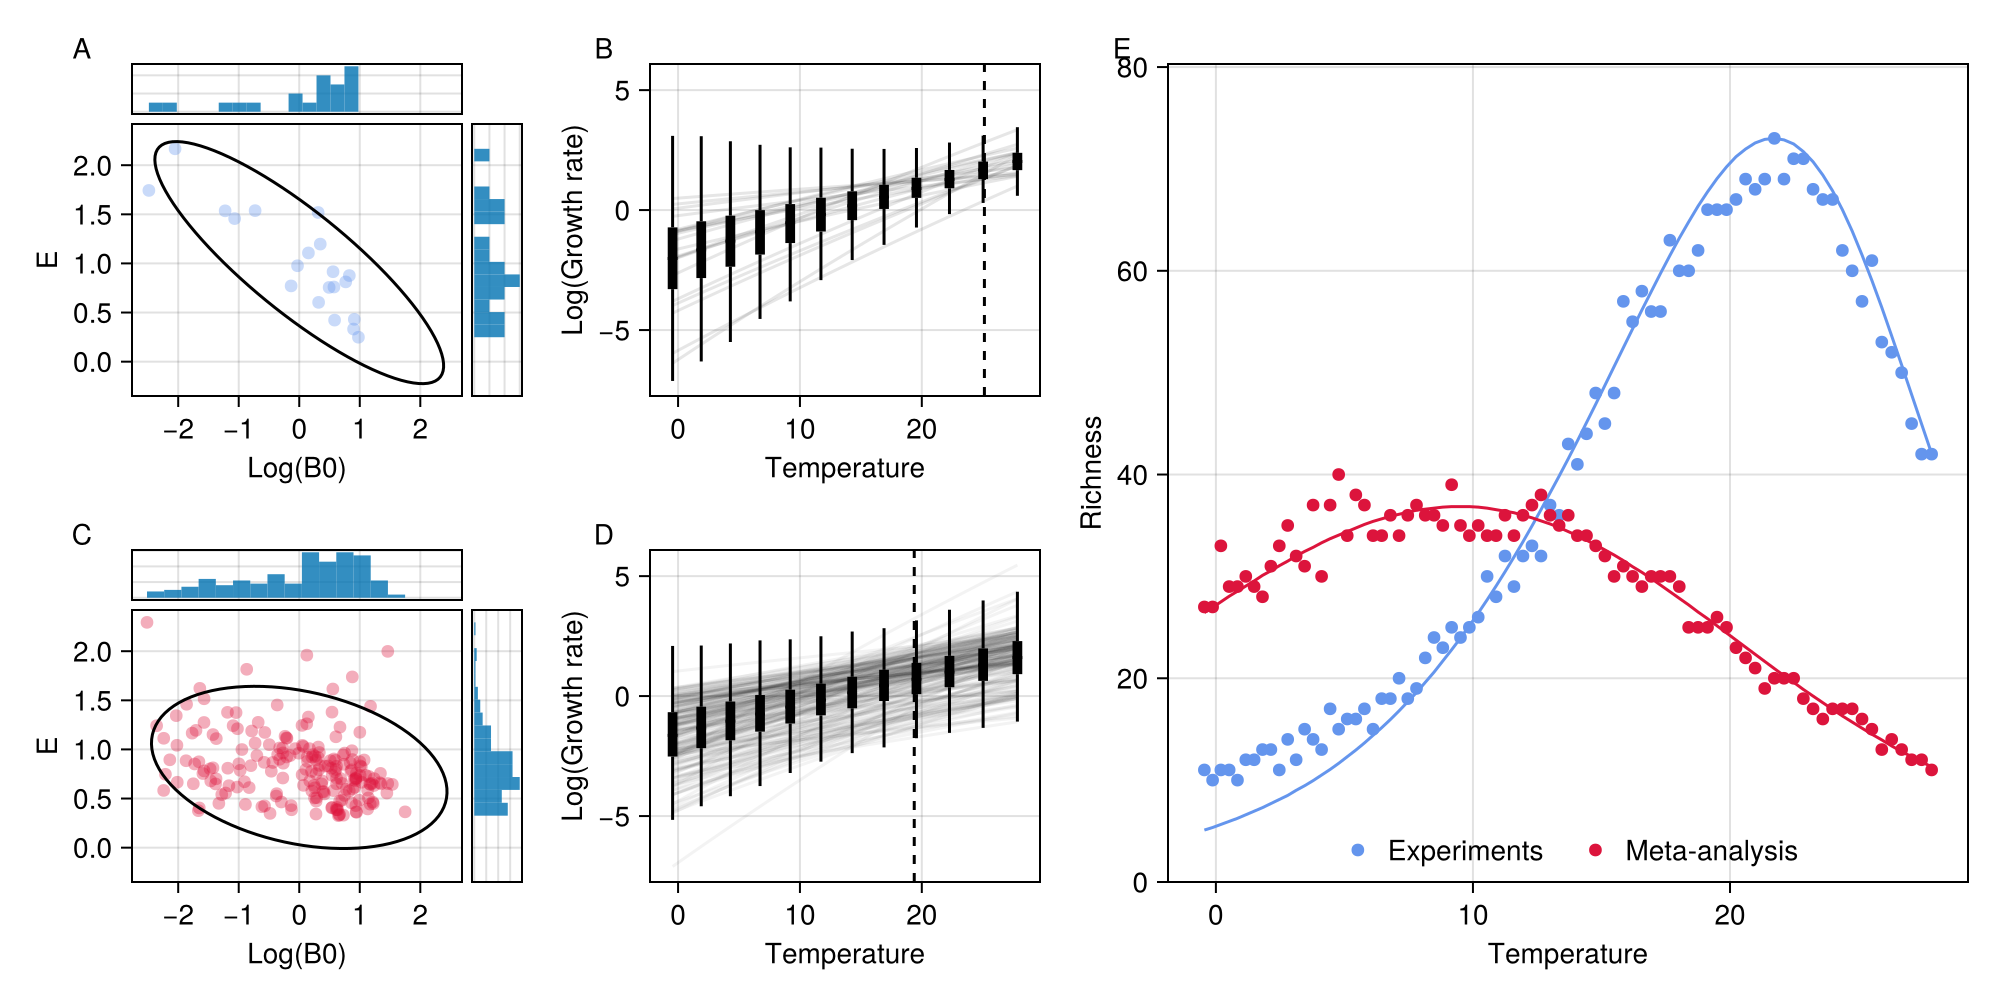

In [14]:

function boltz(B0,E,ΔT)
    B0  -E * ΔT
end

N_rep = 1000

#set up grid
#plotting
f = Figure(size = (1000, 500))

ga1 = f[1,1][1,1] = GridLayout()
ga2 = f[1,1][1,2] = GridLayout()

gb1 = f[2, 1][1,1] = GridLayout()
gb2 = f[2, 1][1,2] = GridLayout()

# gc = f[1:2, 2] = GridLayout()

#set axes
ag1 = ga1[1,1] = Axis(f, height = 25)
ag2 = ga1[2,1] = Axis(f, xlabel = "Log(B0)", ylabel = "E")
ag3 = ga1[2,2] = Axis(f, width = 25)
ag4 = ga2[1,1] = Axis(f, xlabel = "Temperature", ylabel = "Log(Growth rate)")    

#set axes
am1 = gb1[1,1] = Axis(f, height = 25)
am2 = gb1[2,1] = Axis(f, xlabel = "Log(B0)", ylabel = "E")
am3 = gb1[2,2] = Axis(f, width = 25)
am4 = gb2[1,1] = Axis(f, xlabel = "Temperature", ylabel = "Log(Growth rate)")    

a_richness = gc = Axis(f[1:2, 2], xlabel = "Temperature", ylabel = "Richness", width = 400)

colgap!(ga1,5)
rowgap!(ga1,5)

colgap!(gb1,5)
rowgap!(gb1,5)

# #Labels
Label(f[1,1][1,1,TopLeft()],"A")
Label(f[1,1][1,2,TopLeft()],"B")
Label(f[2,1][1,1,TopLeft()],"C")
Label(f[2,1][1,2,TopLeft()],"D")
Label(f[1:2,2,TopLeft()],"E")

#scatter plot
linkxaxes!(am2, am1, ag2, ag1)
linkyaxes!(am2, am3, ag2, ag3)
linkyaxes!(ag4, am4)
        
#calculate conf ellipse
ellipse_exp = ErrorEllipse(dB_exp, 0.95)
ellipse_meta = ErrorEllipse(dB_meta, 0.95)
    
#exp
hist!(ag1, df_exp[:,1])
# plot
scatter!(ag2, float.(df_exp[:,1]), float.(df_exp[:,2]), 
    color = ("cornflowerblue",0.35))

lines!(ag2, ellipse_exp[1,:], ellipse_exp[2,:], color = "black")
hist!(ag3, df_exp[:,2], direction = :x)
hidedecorations!(ag1, grid = false)
hidedecorations!(ag3, grid = false)

#plot TPC curves
[lines!(ag4, T_plot, boltz.(df_exp[i,1],df_exp[i,2], T_vec), color = ("black", 0.1)) for i = 1:size(df_exp)[1]]
        
#plot distributions
sim_exp_data = rand(dB_exp,N_rep)'
for T = range(-2,2,length = 12)
    boxplot!(ag4, repeat([GLV.ΔT_to_C(T, 13.0)], N_rep), boltz.(sim_exp_data[:,1], sim_exp_data[:,2],T) , color = "black", show_outliers = false)
end

#get min variance temp
min_var_exp = [GLV.ΔT_to_C(dB_exp.Σ[1,2] / dB_exp.Σ[2,2], 13.0)]
vlines!(ag4, min_var_exp, color = "black", linestyle = :dash)

#meta
hist!(am1, df_meta[:,1])
# plot
scatter!(am2, float.(df_meta[:,1]), float.(df_meta[:,2]), 
    color = ("crimson",0.35))

lines!(am2, ellipse_meta[1,:], ellipse_meta[2,:], color = "black")
hist!(am3, df_meta[:,2], direction = :x)

hidedecorations!(am1, grid = false)
hidedecorations!(am3, grid = false)

#plot TPC curves
[lines!(am4, T_plot, boltz.(df_meta[i,1],df_meta[i,2],T_vec), color = ("black", 0.05)) for i = 1:size(df_meta)[1]]
#get trait Distributions
sim_meta_data = rand(dB_meta,N_rep)'
for T = range(-2,2,length = 12)
    boxplot!(am4, repeat([GLV.ΔT_to_C(T, 13.0)], N_rep), boltz.(sim_meta_data[:,1], sim_meta_data[:,2],T) , color = "black", show_outliers = false)
end
#get min variance temp
min_var_meta = [GLV.ΔT_to_C(dB_meta.Σ[1,2] / dB_meta.Σ[2,2], 13.0)]
vlines!(am4,min_var_meta, color = "black", linestyle = :dash)

scatter!(a_richness, T_plot, sim_exp, color = "cornflowerblue", label = "Experiments")
lines!(a_richness, T_plot, pred_exp, color = "cornflowerblue")

scatter!(a_richness, T_plot, sim_meta, color = "crimson", label = "Meta-analysis")
lines!(a_richness, T_plot, pred_meta , color = "crimson")

ylims!(a_richness, (0, 1.1 * maximum(hcat(pred_exp,pred_meta))))
Legend(f[1:2, 2], a_richness, orientation = :horizontal, halign = :center, valign = :bottom, framevisible = false)

f

In [7]:
save("../docs/Figures/grw_data.pdf", f)

CairoMakie.Screen{PDF}
